# <center>Random Forest Classifier</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
#from skopt import BayesSearchCV
from keras.datasets import fashion_mnist
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import load

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import cross_val_score
SEED = 42

In [ ]:
#pip install --upgrade scikit-learn
!pip install scikit-learn==1.2.2

     ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
     -- ------------------------------------- 0.5/8.3 MB 9.4 MB/s eta 0:00:01
     ------ --------------------------------- 1.4/8.3 MB 14.3 MB/s eta 0:00:01
     ---------- ----------------------------- 2.1/8.3 MB 14.7 MB/s eta 0:00:01
     --------------- ------------------------ 3.1/8.3 MB 16.4 MB/s eta 0:00:01
     -------------------- ------------------- 4.1/8.3 MB 17.6 MB/s eta 0:00:01
     -------------------------- ------------- 5.5/8.3 MB 18.4 MB/s eta 0:00:01
     ------------------------------- -------- 6.6/8.3 MB 20.0 MB/s eta 0:00:01
     ------------------------------------- -- 7.7/8.3 MB 20.6 MB/s eta 0:00:01
     ---------------------------------------  8.3/8.3 MB 20.3 MB/s eta 0:00:01
     ---------------------------------------- 8.3/8.3 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successf

## LOADING FASHION MNIST DATA

In [2]:
# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
#Flattening each input image
X_train_flat = X_train.reshape(X_train.shape[0], 28*28)
X_test_flat = X_test.reshape(X_test.shape[0], 28*28)

## Exploratory Data Analysis

In [ ]:
print("Number of samples in the dataset:", len(X_train))
print("Shape of each sample:", X_train[0].shape)
print("Unique labels:", np.unique(y_train))

Number of samples in the dataset: 60000
Shape of each sample: (28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Print the dimensions of the dataset
print('Train: X = ', X_train.shape)
print('Test: X = ', X_test.shape)
print('Test: y = ', y_test.shape)
print('Train: y = ', y_train.shape)

Train: X =  (60000, 28, 28)
Test: X =  (10000, 28, 28)
Test: y =  (10000,)
Train: y =  (60000,)


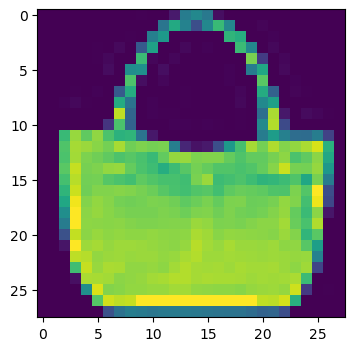

8


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

# Assuming X_train_flat is a NumPy array and y_train is a NumPy array or list with labels
idx = 100

# Use direct indexing for NumPy array
grid_data = X_train_flat[idx].reshape(28, 28)

plt.imshow(grid_data, interpolation="none", cmap="viridis")
plt.show()

# Assuming y_train is a NumPy array or list with labels
print(y_train[idx])

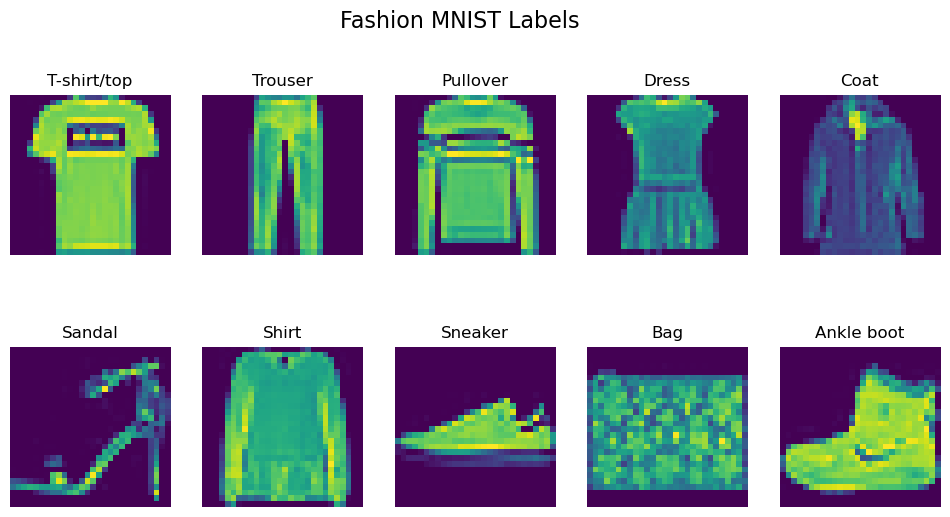

In [ ]:
# Mapping of label indices to label names
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Display one image for each label in black and white
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Fashion MNIST Labels", fontsize=16)

for label in range(10):
    # Find the index of the first image with the given label
    index = np.where(y_train == label)[0][0]

    # Reshape the image to 28x28
    image = X_train[index].reshape(28, 28)

    # Display the image in black and white
    axs[label // 5, label % 5].imshow(image, cmap="viridis")
    axs[label // 5, label % 5].set_title(label_mapping[label])
    axs[label // 5, label % 5].axis("off")

plt.show()

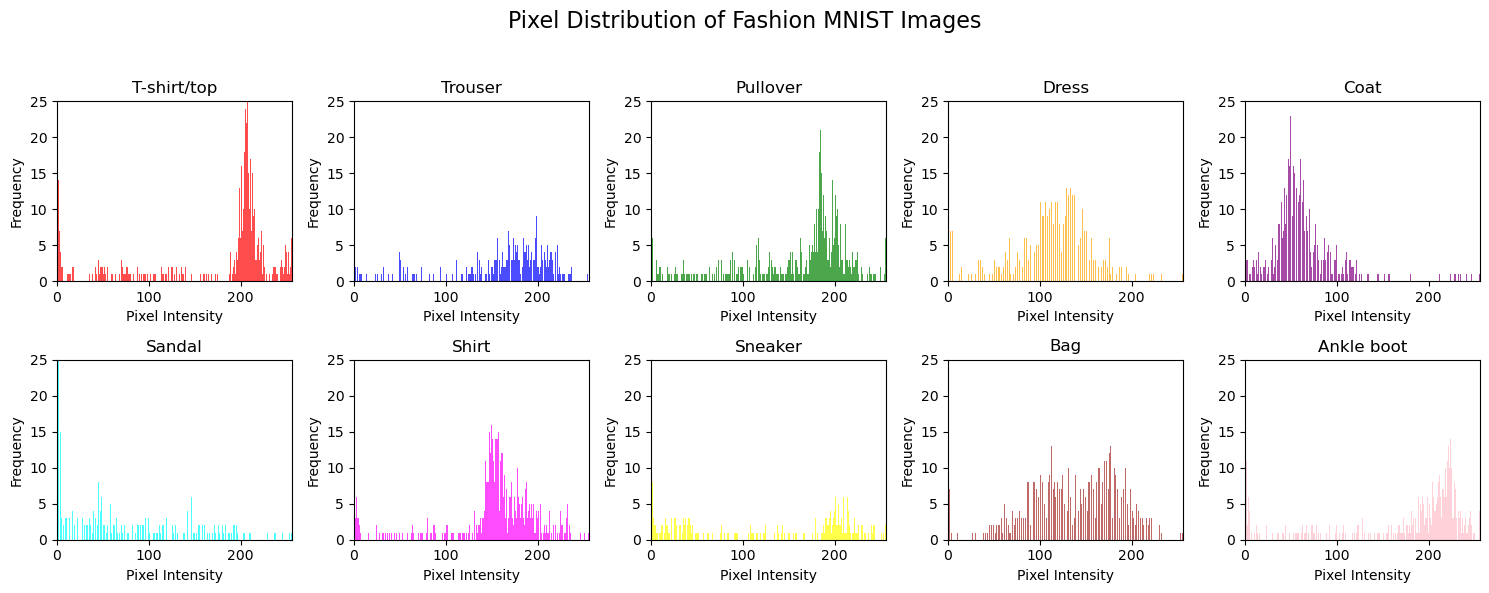

In [ ]:
# Define a list of colors for histograms
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Create a 2x5 grid for subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Pixel Distribution of Fashion MNIST Images", fontsize=16)

# Display pixel distribution for each label in a single graph
for label in range(10):
    # Find the index of the first image with the given label
    index = np.where(y_train == label)[0][0]

    # Reshape the image to 28x28
    image = X_train[index].reshape(28, 28)

    # Flatten the image to a 1D array for histogram
    pixel_values = image.flatten()

    # Plot the pixel distribution histogram with different colors
    axs[label // 5, label % 5].hist(pixel_values, bins=256, range=(0, 256), color=colors[label], alpha=0.7)
    axs[label // 5, label % 5].set_title(label_mapping[label])
    axs[label // 5, label % 5].set_xlabel("Pixel Intensity")
    axs[label // 5, label % 5].set_ylabel("Frequency")
    axs[label // 5, label % 5].set_xlim([0, 256])
    axs[label // 5, label % 5].set_ylim([0, 25])  # Set y-axis limit to 50

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Dimensionality Reduction using Eigen Values

In [ ]:
# Standardize the data (mean=0 and variance=1) before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
print(X_train_scaled.shape)

(60000, 784)


In [ ]:
cov_matrix = np.matmul(X_train_scaled.T, X_train_scaled)
cov_matrix.shape

(784, 784)

In [ ]:
from scipy.linalg import eigh


values, vectors = eigh(cov_matrix, eigvals = (782, 783))
vectors = vectors.T
print(vectors.shape, values)

(2, 784) [ 6780643.18144713 10388100.64854732]


C:\Users\juvva\AppData\Local\Temp\ipykernel_27400\2835061625.py:4: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  values, vectors = eigh(cov_matrix, eigvals = (782, 783))


In [ ]:
new_coordinates = np.matmul(vectors, X_train_scaled.T)
print("Resultant shape:", vectors.shape,  "*", X_train_scaled.shape, "is",new_coordinates.shape )

Resultant shape: (2, 784) * (60000, 784) is (2, 60000)


In [ ]:
new_coordinates = np.vstack((new_coordinates, y_train)).T
df_eigen = pd.DataFrame(data = new_coordinates, columns = ("1st principal", "2nd principal", "labels"))
df_eigen.head()

,1st principal,2nd principal,labels
0,20.866749,0.801175,9.0
1,-4.968512,-17.074206,0.0
2,-12.296101,9.601641,0.0
3,-11.576765,0.311206,3.0
4,-12.867738,-8.963833,0.0


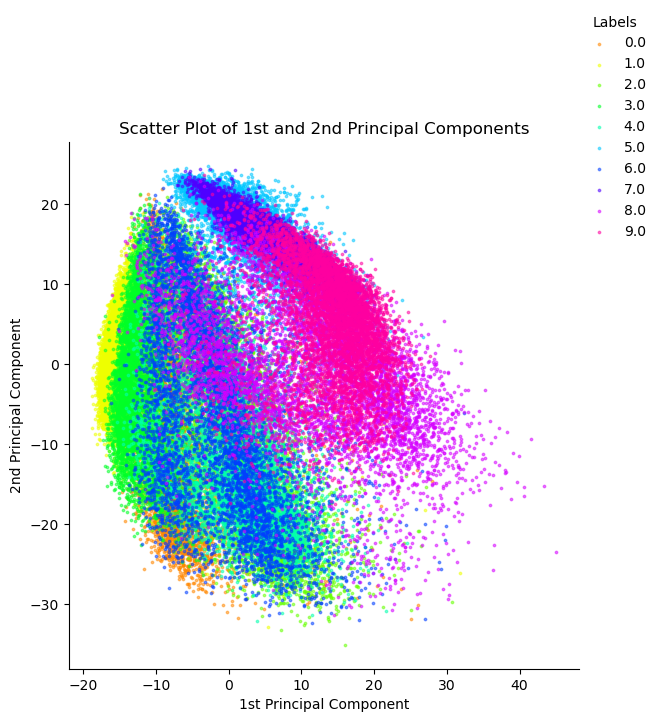

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with columns "1st principal", "2nd principal", and "labels"

# Set a consistent color palette for better visualization
palette = sns.color_palette("hsv", df_eigen['labels'].nunique())

# Create a FacetGrid
g = sns.FacetGrid(df_eigen, hue="labels", palette=palette, height=6)

# Use plt.scatter to specify marker style, size, and transparency
g.map(plt.scatter, "1st principal", "2nd principal", marker='o', s=3, alpha=0.5)

# Add a legend outside the plot for better readability
g.add_legend(title="Labels", bbox_to_anchor=(1, 1))

# Set plot title and labels
plt.title("Scatter Plot of 1st and 2nd Principal Components")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")

plt.show()


## Dimensionality Reduction using scikit-learn PCA

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()

In [ ]:
pca.n_components = 2
pca_data = pca.fit_transform(X_train_scaled)
pca_data.shape

(60000, 2)

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.364981799107024

In [ ]:
pca_data = np.vstack((pca_data.T, y_train)).T
pca_df = pd.DataFrame(data = pca_data, columns = ("1st principal", "2nd principal", "labels"))
pca_df.head()

,1st principal,2nd principal,labels
0,-0.801175,20.866749,9.0
1,17.074206,-4.968512,0.0
2,-9.601641,-12.296101,0.0
3,-0.311206,-11.576765,3.0
4,8.963833,-12.867738,0.0


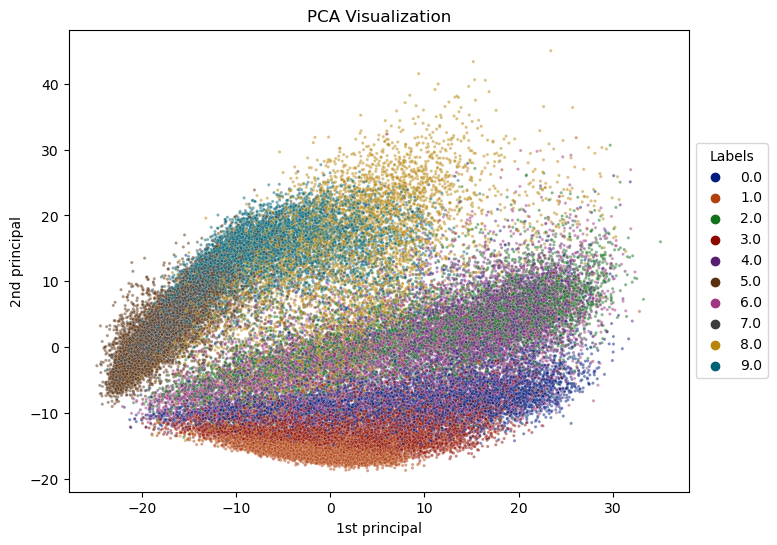

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size for better visibility
plt.figure(figsize=(8, 6))

# Use a colorful palette (e.g., "deep")
color_palette = sns.color_palette("dark")

# Customize the scatter plot
scatter = sns.scatterplot(x="1st principal", y="2nd principal", hue="labels", data=pca_df, palette=color_palette, alpha=0.5, s=5, edgecolor='w')

# Add a legend outside the plot
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Labels")

# Show the plot
plt.title('PCA Visualization')
plt.show()


### Visualizing 99% variance ratio

In [ ]:
from sklearn.decomposition import PCA

# with n_components=0.95, in the reduced dataset (X_train_reduced) we got only 187 features (out of original 784)
# , and there was significant loss of information (quality) in the 'recovered' (decompressed) images.
# Hence, I have selected n_components=0.99, which gives 459 features (out of original 784)
# and there is no significant loss of information (quality) in the 'recovered' images

pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
pca.n_components_

459

In [ ]:
# Checking if hit your 99% minimum?
np.sum(pca.explained_variance_ratio_)

0.9900347820630976

In [ ]:
# use inverse_transform to decompress back to 784 dimensions

X_train_recovered = pca.inverse_transform(X_train_reduced)
X_train_recovered.shape

(60000, 784)

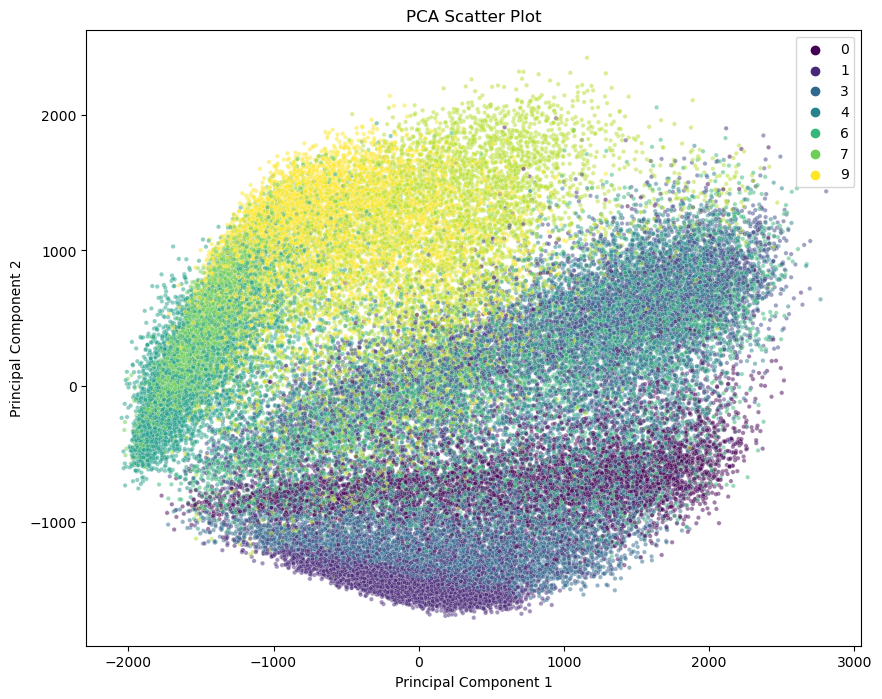

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming X_train_reduced is your reduced dataset and y_train is the corresponding labels

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_train_reduced, columns=[f"principal_{i+1}" for i in range(X_train_reduced.shape[1])])
pca_df["labels"] = y_train

# Scatter plot in the reduced PCA space
plt.figure(figsize=(10, 8))
sns.scatterplot(x="principal_1", y="principal_2", hue="labels", data=pca_df, palette="viridis", alpha=0.5,s=10 )
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()


## ## Dimensionality Reduction using scikit-learn T-SNE

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components = 2, random_state=42)
tsne_data = model.fit_transform(X_train_scaled)

In [ ]:
tsne_data = np.vstack((tsne_data.T, y_train)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("1st principal", "2nd principal", "labels"))
tsne_df.head()

,1st principal,2nd principal,labels
0,-45.654358,69.641785,9.0
1,41.303070,-24.201971,0.0
2,-8.605955,-28.881353,0.0
3,12.781245,-40.970432,3.0
4,9.886556,-64.791573,0.0


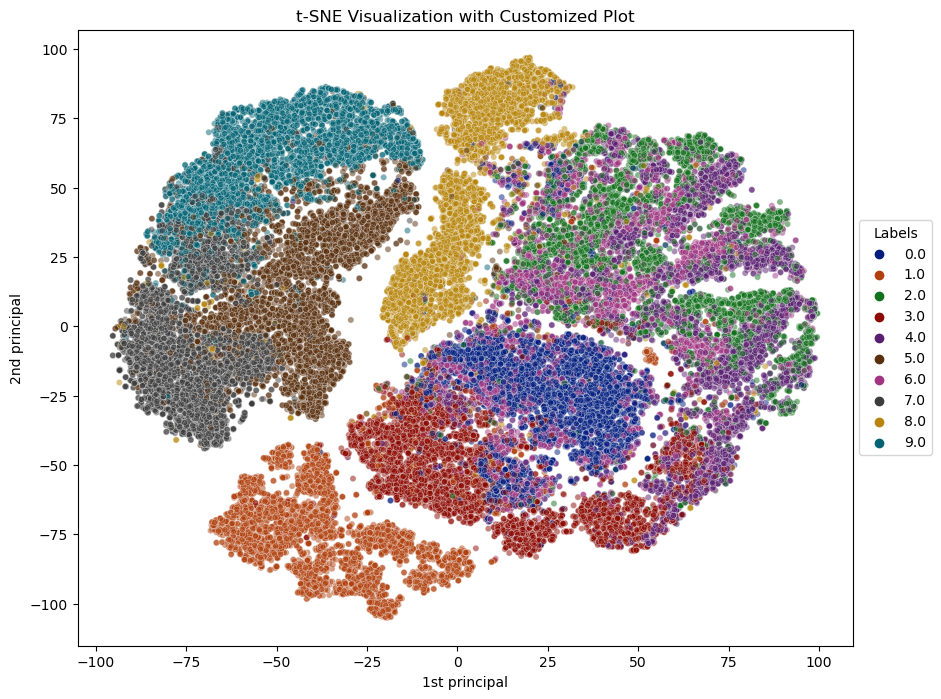

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size for better visibility
plt.figure(figsize=(10, 8))

color_palette = sns.color_palette("dark")

# Customize the scatter plot
scatter = sns.scatterplot(x="1st principal", y="2nd principal", hue="labels", data=tsne_df, palette=color_palette, alpha=0.5, s=20, edgecolor='w')

# Add a legend outside the plot
scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Labels")

# Show the plot
plt.title('t-SNE Visualization with Customized Plot')
plt.show()


## Model Building

In [7]:
#Flattening each input image
X_train_flat = X_train.reshape(X_train.shape[0], 28*28)
X_test_flat = X_test.reshape(X_test.shape[0], 28*28)

#Normalizing
X_train_normalized = X_train_flat/255
X_test_normalized = X_test_flat/255

In [8]:
# Print the dimensions of the dataset after normalizing
print('Train: X = ', X_train_normalized.shape)
print('Test: X = ', X_test_normalized.shape)

Train: X =  (60000, 784)
Test: X =  (10000, 784)


## RandomForest for Fashion Mnist classification

In [4]:
# Create a basic random forest classifier object
default_model = RandomForestClassifier()

# Print the hyperparameters for the basic model
print(f"The hyperparameters for the basic model are:")
print(f"n_estimators: {default_model.n_estimators}")
print(f"max_depth: {default_model.max_depth}")
print(f"min_samples_split: {default_model.min_samples_split}")
print(f"min_samples_leaf: {default_model.min_samples_leaf}")


The hyperparameters for the basic model are:
n_estimators: 100
max_depth: None
min_samples_split: 2
min_samples_leaf: 1


In [5]:
# Create a RandomForestClassifier object
default_model = RandomForestClassifier(random_state=42)

In [9]:
# Fit the model on the entire training set
default_model.fit(X_train_normalized, y_train)

RandomForestClassifier(random_state=42)




Random Forest model with default parameters:

Test Accuracy: 87.64%
Precision: 0.8753
Recall: 0.8764
F1-Score: 0.8749


Confusion Matrix:


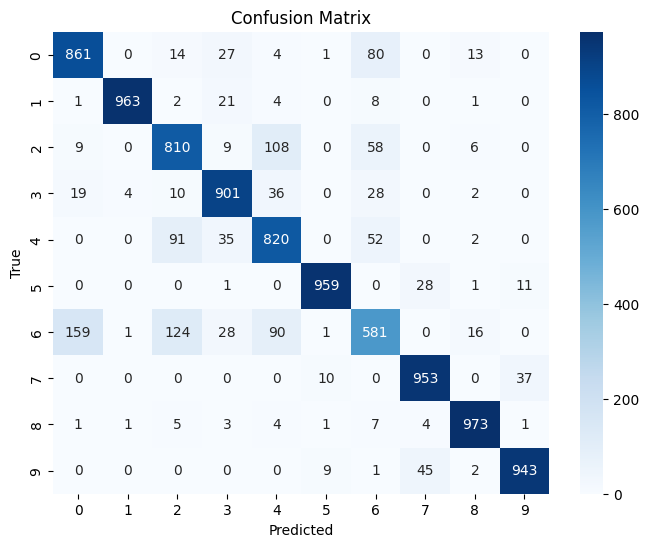

In [10]:
# Predictions on the test set
y_test_pred = default_model.predict(X_test_normalized)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nRandom Forest model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
from google.colab import drive
import joblib

# Specify the path to your Google Drive folder
drive_folder_path = '/content/drive/MyDrive/Colab Notebooks/'

# Save the joblib file to the Google Drive folder
joblib.dump(default_model, drive_folder_path + 'Default_RF_Classifier.joblib')


['/content/drive/MyDrive/Colab Notebooks/Default_RF_Classifier.joblib']

## Hyperparameter tuning

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=SEED)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [20,50],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2]
}

grid_search = GridSearchCV(
    rf_classifier,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='accuracy',  # Accuracy as metric
    verbose=10,  # Adjust verbosity level (0 for no output, higher integers for more details)
)

grid_search.fit(X_train_normalized, y_train)

# Access the grid search results
grid_results = grid_search.cv_results_

# Create a DataFrame to store the results
grid_results_df = pd.DataFrame({
    'Mean Score': grid_results['mean_test_score'],
    'Std Dev Score': grid_results['std_test_score'],
    'Params': grid_results['params']
})

grid_results_df = grid_results_df.sort_values(by='Mean Score', ascending=False)
header = ["Index", "Mean Score", "Std Dev Score", "Params"]
grid_results_df.index.name = "Index"
grid_results_df.reset_index(inplace=True)

# Display the grid search results
print(grid_results_df.to_markdown(headers=header, index=False))
print("\n" + "="*40 + "\n")

# Print the best hyperparameters
best_params_rf = grid_search.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)


In [ ]:
# Train the model on the whole training set using the best hyperparameters
best_model = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_classifiers(estimator, X_train, y_train, cv, name):
    # Initialize lists to store metrics for each fold
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train the model on the training fold
        estimator.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation fold
        y_val_pred = estimator.predict(X_val_fold)

        # Calculate metrics for the current fold
        accuracy_fold = accuracy_score(y_val_fold, y_val_pred)
        precision_fold = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall_fold = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1_fold = f1_score(y_val_fold, y_val_pred, average='weighted')

        # Append metrics to the lists
        accuracy_list.append(accuracy_fold)
        precision_list.append(precision_fold)
        recall_list.append(recall_fold)
        f1_list.append(f1_fold)

        # Print metrics for the current fold
        print(f"Fold {fold + 1} - {name} model:")
        print(f"  - Accuracy: {accuracy_fold * 100:.2f}%")
        print(f"  - Precision: {precision_fold:.4f}")
        print(f"  - Recall: {recall_fold:.4f}")
        print(f"  - F1-Score: {f1_fold:.4f}")
        print("\n" + "="*40 + "\n")

    # Calculate and print average metrics across all folds
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)

    print(f"Average {name} model metrics across all folds:")
    print(f"  - Average Accuracy: {avg_accuracy * 100:.2f}%")
    print(f"  - Average Precision: {avg_precision:.4f}")
    print(f"  - Average Recall: {avg_recall:.4f}")
    print(f"  - Average F1-Score: {avg_f1:.4f}")
    print("\n" + "="*40 + "\n")

In [ ]:
# Use the train_classifiers function to print cross-fold metrics
train_classifiers(best_model, X_train_normalized, y_train, StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), "Random Forest")

Fold 1 - Random Forest model:
  - Accuracy: 88.12%
  - Precision: 0.8805
  - Recall: 0.8812
  - F1-Score: 0.8798


Fold 2 - Random Forest model:
  - Accuracy: 87.98%
  - Precision: 0.8788
  - Recall: 0.8798
  - F1-Score: 0.8783


Fold 3 - Random Forest model:
  - Accuracy: 88.08%
  - Precision: 0.8798
  - Recall: 0.8808
  - F1-Score: 0.8794


Fold 4 - Random Forest model:
  - Accuracy: 88.38%
  - Precision: 0.8834
  - Recall: 0.8838
  - F1-Score: 0.8822


Fold 5 - Random Forest model:
  - Accuracy: 88.29%
  - Precision: 0.8816
  - Recall: 0.8829
  - F1-Score: 0.8810


Average Random Forest model metrics across all folds:
  - Average Accuracy: 88.17%
  - Average Precision: 0.8808
  - Average Recall: 0.8817
  - Average F1-Score: 0.8802




In [20]:
# Best hyperparameters chosen: 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100

best_model = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth = 50,min_samples_leaf=1,min_samples_split=2)


In [21]:
best_model.fit(X_train_normalized, y_train)


RandomForestClassifier(max_depth=50, random_state=42)

Test Accuracy: 87.6400%
Test Precision: 0.8752
Test Recall: 0.8764
Test F1-Score: 0.8749


Confusion Matrix:


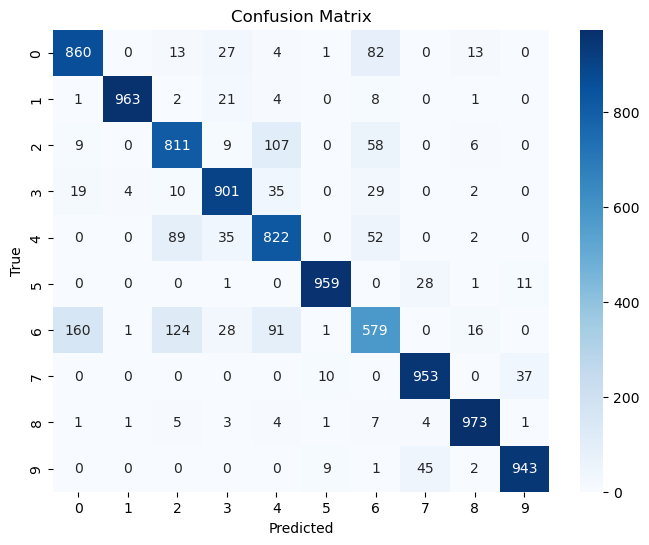

In [ ]:
# Evaluate on the test set
y_test_pred = best_model.predict(X_test_normalized)

# Calculate evaluation metrics on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy_test * 100:.4f}%")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1-Score: {f1_test:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [28]:
# Specify the path to your Google Drive folder
drive_folder_path = '/content/drive/MyDrive/Colab Notebooks/'

# Save the joblib file to the Google Drive folder
joblib.dump(best_model, drive_folder_path + 'Hypertuned_RF_Classifier.joblib')


['/content/drive/MyDrive/Colab Notebooks/Hypertuned_RF_Classifier.joblib']

### Finding best hyper parameters using GridSearch with PCA approach


Dimensionality reduction will be applied to the training dataset to reduce the number of features, aiming to expedite the grid search and prediction processes. Additionally, scores will be computed based on the reduced features. An assessment will be conducted to determine if the application of dimensionality reduction results in a significant loss of information from the images in the training dataset. If a substantial loss is observed, dimensionality reduction will not be employed for the training dataset. It is important to note that, given the dataset's characteristics, there is no need for converting a 3-dimensional dataset to a 2-dimensional plane or similar transformations. Manifold techniques will not be utilized for dimensionality reduction in this context; instead, a Projection technique will be applied.

In [ ]:
from sklearn.decomposition import PCA

# with n_components=0.95, in the reduced dataset (X_train_reduced) we got only 187 features (out of original 784)
# , and there was significant loss of information (quality) in the 'recovered' (decompressed) images.
# Hence, I have selected n_components=0.99, which gives 459 features (out of original 784)
# and there is no significant loss of information (quality) in the 'recovered' images

pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
pca.n_components_

459

In [ ]:
# Checking if hit your 99% minimum?
np.sum(pca.explained_variance_ratio_)

0.9900347820630976

In [ ]:
# use inverse_transform to decompress back to 784 dimensions

X_train_recovered = pca.inverse_transform(X_train_reduced)

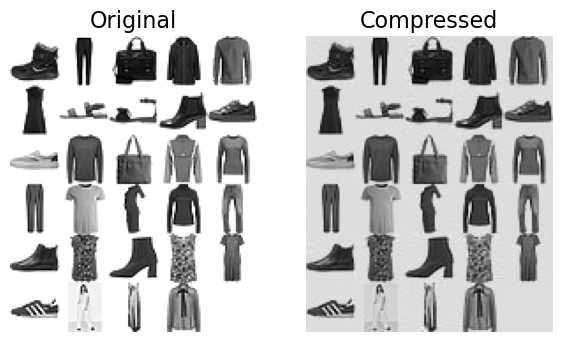

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
# Plotting 'original' image
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
# Plotting the corresponding 'recovered' image
plot_digits(X_train_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

## Interpretability - Feature Importance


Feature Importance:
         Feature    Importance
546  feature_546  1.091544e-02
262  feature_262  7.491212e-03
602  feature_602  7.445132e-03
406  feature_406  7.040607e-03
574  feature_574  6.803885e-03
..           ...           ...
26    feature_26  2.462712e-06
55    feature_55  2.370630e-06
27    feature_27  2.072237e-06
1      feature_1  4.387575e-07
0      feature_0  3.610304e-07

[784 rows x 2 columns]


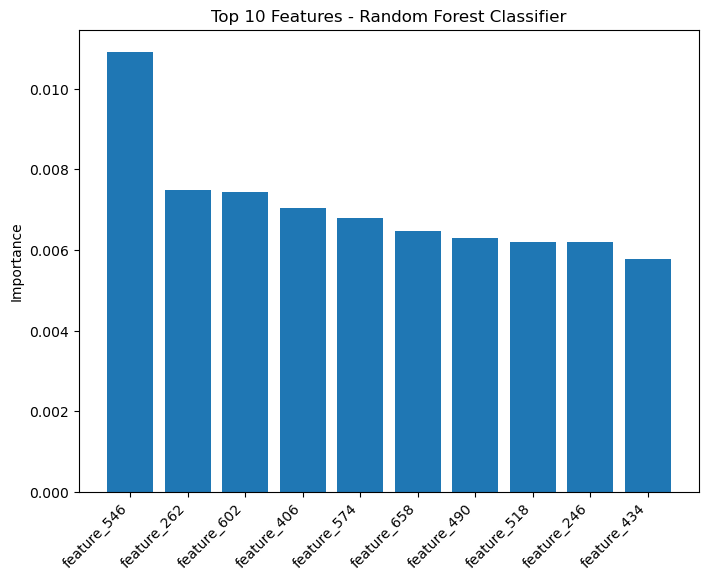

In [ ]:
# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# If X_train is a NumPy array and doesn't have columns, create a list of feature names
feature_names = [f'feature_{i}' for i in range(X_train_normalized.shape[1])]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nFeature Importance:")
print(feature_importance_df)

# Plot the top N important features
top_n = 10  # Change this value to display a different number of top features
plt.figure(figsize=(8, 6))
plt.bar(feature_importance_df['Feature'][:top_n], feature_importance_df['Importance'][:top_n])
plt.ylabel('Importance')
plt.title(f'Top {top_n} Features - Random Forest Classifier')
plt.xticks(rotation=45, ha='right')
plt.show()

### Checking whether saved models results correct output

Evaluation for Default Random Forest:



Random Forest model with default parameters:

Test Accuracy: 87.64%
Precision: 0.8753
Recall: 0.8764
F1-Score: 0.8749


Confusion Matrix:


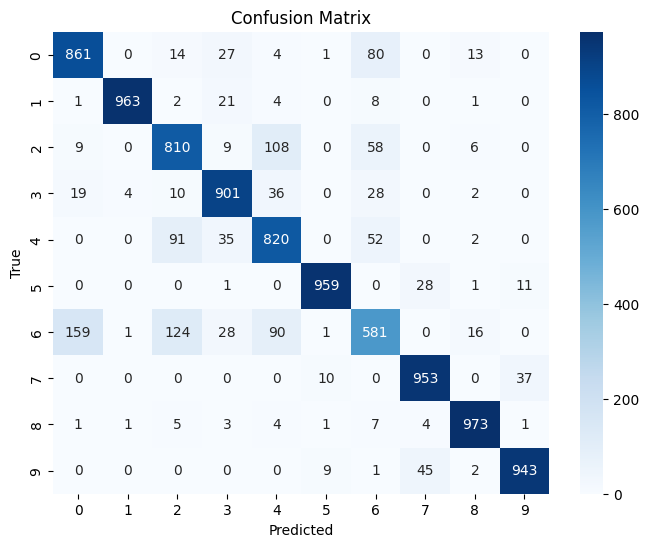

In [29]:
A = load('/content/drive/MyDrive/Colab Notebooks/Default_RF_Classifier.joblib')

# Evaluate the default random forest
print("Evaluation for Default Random Forest:")

y_test_pred = A.predict(X_test_normalized)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nRandom Forest model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Evaluation for Hyper-tuned Random Forest:



Random Forest model with default parameters:

Test Accuracy: 87.64%
Precision: 0.8752
Recall: 0.8764
F1-Score: 0.8749


Confusion Matrix:


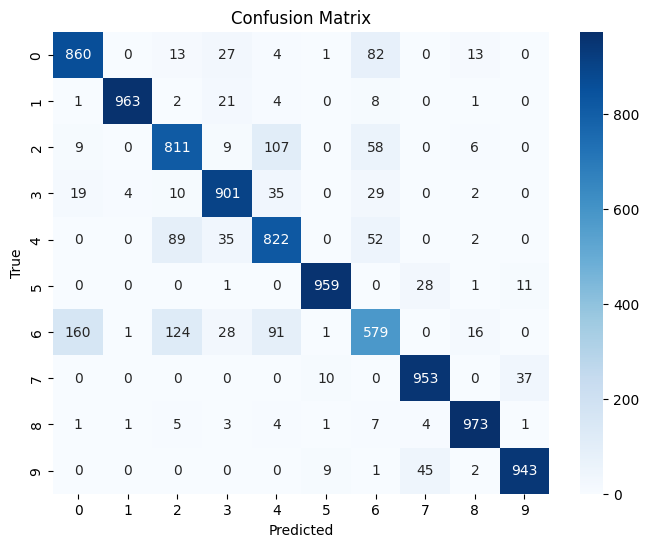

In [30]:
B = load('/content/drive/MyDrive/Colab Notebooks/Hypertuned_RF_Classifier.joblib')
# Evaluate the hyper-tuned random forest
print("Evaluation for Hyper-tuned Random Forest:")

y_test_pred = B.predict(X_test_normalized)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nRandom Forest model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()